# ALS project

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from pandas_profiling import ProfileReport
import webbrowser, os

In [417]:
import pickle
import h5py
import string
import math

In [43]:
def feature_report(df):
    '''
    print a report of every feature
    '''
    profile = ProfileReport(df, bins=30)
    profile.to_file(outputfile="output.html")
    webbrowser.open('file://' + os.path.realpath("output.html"))
    #end function

In [310]:
def dups(df):
    '''
    finds duplicated values in dataframe, requires 'subject_id'
    '''
    bill = df.copy()
    dup_cols = []
    bill['test_dup']= np.ones(len(df))
    g = bill.groupby('subject_id').count()
    print("Length df: {}".format(len(df)))
    print("Length g: {}".format(len(g)))
    for c in range(len(g.columns)):
        mask = (g.iloc[:,c]>1)
        dup_cols.append(sum(mask))
    print("Number subjects duplicated: {}".format(np.max(dup_cols)))
    bill.drop('test_dup', axis=1, inplace=True)
    if np.max(dup_cols)>=1:
        return g[mask]

In [569]:
def to_zero_one(df, col_list):
    '''
    convert nans to 0
    input:
        df = dataframe
        col_list = list of columns to apply the change
    '''
    for col in col_list:
        df[col].fillna(int(0), inplace=True)

In [570]:
def ints(df, col_list):
    '''
    makes column integer values
    input:
        df = dataframe
        col_list = list of columns to apply the change
    '''
    for col in col_list:
        df[col] = df[col].astype(int)

## treatment arms  
- single entry per subject
- 'placebo' =  only placebo subjects (n=2912)

In [742]:
txt = pd.read_csv("data/Treatment.csv")

In [743]:
txt.head()

,subject_id,Study_Arm,Treatment_Group_Delta
0,89,Active,NaN
1,329,Active,0.0
2,348,Placebo,0.0
3,406,Active,NaN
4,411,Active,NaN


In [744]:
# look for duplicted subjects in the dataset
print(len(txt))  # 9640
print(len(set(txt['subject_id'])))  #9640 = all unique subjects

9640
9640


In [745]:
dups(txt)

Length df: 9640
Length g: 9640
Number subjects duplicated: 0


In [746]:
#feature_report(txt)
# placebo = 30.2% of subjects
# active = 69.8% of subjects

In [747]:
# remove the Treatment_Group_Delta column.
txt.drop('Treatment_Group_Delta', axis=1, inplace=True)

In [748]:
# id's of placebo subjects
placebo = txt.loc[txt['Study_Arm']=='Placebo']
print(len(placebo))
placebo.head()

2912


,subject_id,Study_Arm
2,348,Placebo
7,902,Placebo
9,1064,Placebo
11,1312,Placebo
16,2132,Placebo


In [749]:
filename = 'clean_data/txt.csv'
txt.to_csv(filename, index=False)

## ALS history  
- multi-entry  
- make into single entry

In [318]:
# load the dataset
history = pd.read_csv("data/AlsHistory.csv")

In [760]:
print(history.shape)
history.head()

(12058, 12)


,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Spine,Symptom,Symptom_Other_Specify,Location,Site_of_Onset,Onset_Delta,Diagnosis_Delta
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1706.0,-1068.0
2,348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Onset: Other,-501.0,-302.0
3,406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [321]:
dups(history)

Length df: 12058
Length g: 9393
Number subjects duplicated: 2222


,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Other_Specify,Site_of_Onset___Spine,Subject_ALS_History_Delta,Disease_Duration,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Onset_Delta,Diagnosis_Delta,test_dup
subject_id,,,,,,,,,,,,,,,,
649,0,0,0,0,0,0,3,0,2,0,2,0,1,2,0,3
1234,0,0,0,0,0,0,3,0,2,0,2,0,1,2,0,3
2540,0,0,0,0,0,0,2,0,1,0,1,0,1,1,0,2
2956,0,0,0,0,0,0,2,0,1,0,1,0,1,1,0,2
3085,0,0,0,0,0,0,2,0,1,0,1,0,1,1,0,2
3551,0,0,0,0,0,0,2,0,1,0,1,0,1,1,0,2
3809,0,0,0,0,0,0,2,0,1,0,1,0,1,1,0,2
3870,0,0,0,0,0,0,2,0,1,0,1,0,1,1,0,2
4390,0,0,0,0,0,0,2,0,1,0,1,0,1,1,0,2


In [322]:
# delete 'Site_of_Onset___Other_Specify' - empty
history.drop('Site_of_Onset___Other_Specify', axis=1, inplace=True)

In [323]:
# delete 'Location_Other_Specify' - empty
history.drop('Location_Other_Specify', axis=1, inplace=True)

In [324]:
# delete 'Disease_Duration' - empty
history.drop('Disease_Duration', axis=1, inplace=True)

In [325]:
# delete 'Subject_ALS_History_Delta' - empty
history.drop('Subject_ALS_History_Delta', axis=1, inplace=True)

In [761]:
print(history.shape)
history.head()

(12058, 12)


,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Spine,Symptom,Symptom_Other_Specify,Location,Site_of_Onset,Onset_Delta,Diagnosis_Delta
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1706.0,-1068.0
2,348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Onset: Other,-501.0,-302.0
3,406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Split data - onset and daignosis dates from body location**  
- dates

In [327]:
history_onset_dates = history[['subject_id', 'Onset_Delta', 'Diagnosis_Delta']].copy()

In [328]:
print(history_onset_dates.shape)
history_onset_dates.head()

(12058, 3)


,subject_id,Onset_Delta,Diagnosis_Delta
0,89,NaN,NaN
1,329,-1706.0,-1068.0
2,348,-501.0,-302.0
3,406,NaN,NaN
4,411,NaN,NaN


In [329]:
# remove duplicates
dups(history_onset_dates)
history_onset_dates.drop_duplicates(inplace=True)

Length df: 12058
Length g: 9393
Number subjects duplicated: 2222


In [330]:
print(history_onset_dates.shape)
history_onset_dates.head()

(11609, 3)


,subject_id,Onset_Delta,Diagnosis_Delta
0,89,NaN,NaN
1,329,-1706.0,-1068.0
2,348,-501.0,-302.0
3,406,NaN,NaN
4,411,NaN,NaN


In [331]:
onset = history_onset_dates[[ 'subject_id', 'Onset_Delta', 'Diagnosis_Delta']].copy()

In [332]:
onset.head()

,subject_id,Onset_Delta,Diagnosis_Delta
0,89,NaN,NaN
1,329,-1706.0,-1068.0
2,348,-501.0,-302.0
3,406,NaN,NaN
4,411,NaN,NaN


In [333]:
# delete the empty rows
onset.dropna(axis=0, inplace=True, thresh=2)

In [334]:
onset.head(10)

,subject_id,Onset_Delta,Diagnosis_Delta
1,329,-1706.0,-1068.0
2,348,-501.0,-302.0
5,533,-1023.0,-44.0
6,586,-715.0,-507.0
7,649,-341.0,NaN
10,708,-1070.0,-986.0
11,902,-514.0,-49.0
13,1064,-550.0,-462.0
14,1234,-1181.0,NaN
17,1309,-638.0,-169.0


In [741]:
filename = 'clean_data/onset_date.csv'
onset.to_csv(filename, index=False)

#### History location

Columns ready for analysis = 
- Site_of_Onset___Bulbar
- Site_of_Onset___Limb
- Site_of_Onset___Limb_and_Bulbar
- Site_of_Onset___Other
- Site_of_Onset___Spine
- Site_of_Onset
... can remove the columns above.


In [762]:
history_location = history[['subject_id', 'Site_of_Onset___Bulbar', 
        'Site_of_Onset___Limb', 'Site_of_Onset___Limb_and_Bulbar', 'Site_of_Onset___Other',
        'Site_of_Onset___Spine', 'Symptom', 'Symptom_Other_Specify', 'Location', 
        'Site_of_Onset',]].copy()

In [763]:
print(history_location.shape)
history_location.head()

(12058, 10)


,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Spine,Symptom,Symptom_Other_Specify,Location,Site_of_Onset
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Onset: Other
3,406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [764]:
history_location['Site_of_Onset'].unique()

array([nan, 'Onset: Other', 'Onset: Bulbar', 'Onset: Limb',
       'Onset: Spine', 'Onset: Limb and Bulbar'], dtype=object)

In [765]:
# correct site of onset columns <- 'Site_of_Onset'
def bulbar(row):
    if row['Site_of_Onset___Bulbar'] == 1:
        return 1
    elif row['Site_of_Onset']== 'Onset: Bulbar':
        return 1
    else: 
        return 0

# correct site of onset columns <- 'Site_of_Onset'
def limb(row):
    if row['Site_of_Onset___Limb'] == 1:
        return 1
    elif row['Site_of_Onset']== 'Onset: Limb':
        return 1
    else: 
        return 0

# correct site of onset columns <- 'Site_of_Onset'
def spine(row):
    if row['Site_of_Onset___Spine'] == 1:
        return 1
    elif row['Site_of_Onset']== 'Onset: Spine':
        return 1
    else: 
        return 0

# correct site of onset columns <- 'Site_of_Onset'
def limb_bulbar(row):
    if row['Site_of_Onset___Limb_and_Bulbar'] == 1:
        return 1
    elif row['Site_of_Onset']== 'Onset: Limb and Bulbar':
        return 1
    else: 
        return 0
    
# correct site of onset columns <- 'Site_of_Onset'
def other(row):
    if row['Site_of_Onset___Other'] == 1:
        return 1
    elif row['Site_of_Onset']== 'Onset: Other':
        return 1
    else: 
        return 0

In [766]:
# make 1 and 0 columns with site locations
history_location['site_onset_bulbar'] = history_location.apply(bulbar, axis=1)
history_location['site_onset_limb'] = history_location.apply(limb, axis=1)
history_location['site_onset_spine'] = history_location.apply(spine, axis=1)
history_location['site_onset_other'] = history_location.apply(other, axis=1)
history_location['site_onset_limb_and_bulbar'] = history_location.apply(limb_bulbar, axis=1)

In [767]:
print(history_location.shape)
history_location.head()

(12058, 15)


,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Spine,Symptom,Symptom_Other_Specify,Location,Site_of_Onset,site_onset_bulbar,site_onset_limb,site_onset_spine,site_onset_other,site_onset_limb_and_bulbar
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0
1,329,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0
2,348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Onset: Other,0,0,0,1,0
3,406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0
4,411,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0


In [769]:
# 
history_symptom = history_location[['subject_id','Symptom', 
                                    'Symptom_Other_Specify', 'Location']].copy()

In [771]:
print(history_symptom.shape)
history_symptom.head(20)

(12058, 4)


,subject_id,Symptom,Symptom_Other_Specify,Location
0,89,NaN,NaN,NaN
1,329,NaN,NaN,NaN
2,348,NaN,NaN,NaN
3,406,NaN,NaN,NaN
4,411,NaN,NaN,NaN
5,533,NaN,NaN,NaN
6,586,NaN,NaN,NaN
7,649,WEAKNESS,NaN,FACIAL
8,649,NaN,NaN,NaN
9,649,Speech,NaN,SPEECH


In [774]:
# delete the empty rows
history_symptom.dropna(axis=0, inplace=True, thresh=3)

In [787]:
history_symptom.reset_index(inplace=True, drop=True)

In [788]:
print(history_symptom.shape)
history_symptom.head(10)

(2653, 5)


,subject_id,Symptom,Symptom_Other_Specify,Location,location
0,649,WEAKNESS,NaN,FACIAL,facial
1,649,Speech,NaN,SPEECH,speech
2,1234,Speech,NaN,TONGUE WEAKNESS,tongue weakness
3,1234,Swallowing,NaN,ORAL PNARYNGIAL WEAKNESS,oral pnaryngial weakness
4,2540,WEAKNESS,NaN,RIGHT LEG,right leg
5,2956,WEAKNESS,NaN,LEFT LEG,left leg
6,3085,Speech,NaN,BULBAR,bulbar
7,3551,WEAKNESS,NaN,R ARM,r arm
8,3809,WEAKNESS,NaN,(R) HAND + FOOT,(r) hand + foot
9,3870,WEAKNESS,NaN,ORAL MUSCLES,oral muscles


In [784]:
def make_lower(val):
    w=val.lower()
    return w

In [785]:
# make all values lowercase 
history_symptom['location'] = history_symptom['Location'].apply(make_lower)

In [790]:
# list the unique words
history_symptom['location'].unique()

array(['facial', 'speech', 'tongue weakness', 'oral pnaryngial weakness',
       'right leg', 'left leg', 'bulbar', 'r arm', '(r) hand + foot',
       'oral muscles', 'fingers of both hands', 'tongue arms',
       'left foot drop', 'right thumb & index finger', 'mouth',
       'proximal lower right limb',
       '(r) foot drop few months later (l) ft.', 'throat', 'hands',
       'lower limb right', '(r) shoulder', 'body', 'legs',
       'both legs right hand', 'right foot', 'lue', 'lower limbs',
       'upper extremities', 'left foot', 'speech disturbance',
       'l foot/leg', 'upper arm - (r)', 'right upper extremity',
       'bulbar stage', 'atrophy right leg', '(l arm', 'r leg l leg',
       'legs & arms', 'left hand', 'generalized', '(r) foot',
       'left shoulder', 'right ankleright hip', 'upper limbe',
       'upper & lower limbs', 'right hand', 'left lower limb',
       'bilateral lower extremity', 'motor disfunction right upper limb',
       'leg (bilateral)', '(l) hand',
  

In [792]:
rights = ['r', 'rt', 'right']
lefts = ['l', 'lt' , 'left']


def clean_str(val):
    clean = val.translate(None, string.punctuation)
    words = clean.split()
    return words

def right_side(val):
    words = clean_str(val)
    for word in words:
        if word in rights:
            return 1
        else:
            return 0

def left_side(val):
    words = clean_str(val)
    for word in words:
        if word in rights:
            return 1
        else:
            return 0

In [793]:
history_symptom['right_onset_side'] = history_symptom['Location'].apply(right_side)
history_symptom['left_onset_side'] = history_symptom['Location'].apply(left_side)

TypeError: translate() takes exactly one argument (2 given)

In [791]:
history_symptom.head(20)

,subject_id,Symptom,Symptom_Other_Specify,Location,location
0,649,WEAKNESS,NaN,FACIAL,facial
1,649,Speech,NaN,SPEECH,speech
2,1234,Speech,NaN,TONGUE WEAKNESS,tongue weakness
3,1234,Swallowing,NaN,ORAL PNARYNGIAL WEAKNESS,oral pnaryngial weakness
4,2540,WEAKNESS,NaN,RIGHT LEG,right leg
5,2956,WEAKNESS,NaN,LEFT LEG,left leg
6,3085,Speech,NaN,BULBAR,bulbar
7,3551,WEAKNESS,NaN,R ARM,r arm
8,3809,WEAKNESS,NaN,(R) HAND + FOOT,(r) hand + foot
9,3870,WEAKNESS,NaN,ORAL MUSCLES,oral muscles


## Death :(  
- single entry per subject

In [669]:
death = pd.read_csv("data/DeathData.csv")

In [670]:
print(death.shape)
death.head()

(4634, 3)


,subject_id,Subject_Died,Death_Days
0,89,Yes,218.0
1,411,Yes,141.0
2,708,Yes,250.0
3,902,No,NaN
4,1312,No,NaN


In [671]:
dups(death)

Length df: 4634
Length g: 4633
Number subjects duplicated: 1


,Subject_Died,Death_Days,test_dup
subject_id,,,
442984,2,2,2


In [672]:
# discard value 84 for subject 442984
remove = death.index[(death['subject_id']== 442984) & (death['Death_Days']== 84)].tolist()
death.drop(index=remove, axis=0, inplace=True)

In [673]:
dups(death)

Length df: 4633
Length g: 4633
Number subjects duplicated: 0


In [674]:
death['death_days_trail_start'] = death['Death_Days']

In [675]:
death.drop('Death_Days', axis=1, inplace=True)

In [676]:
# convert subject died to 1=yes, 0=no
death['Subject_Died'].replace({'Yes': int(1), 'No': int(0)}, inplace=True)

In [677]:
death.head()

,subject_id,Subject_Died,death_days_trail_start
0,89,1,218.0
1,411,1,141.0
2,708,1,250.0
3,902,0,NaN
4,1312,0,NaN


## Riluzole  
shape: 1 entry per subject (not all subjects)

In [678]:
riluzole = pd.read_csv("data/Riluzole.csv")

In [679]:
print(riluzole.shape)
riluzole.head()

(8817, 3)


,subject_id,Subject_used_Riluzole,Riluzole_use_Delta
0,89,Yes,0.0
1,348,Yes,0.0
2,406,Yes,0.0
3,411,Yes,0.0
4,586,No,0.0


In [680]:
dups(riluzole)

Length df: 8817
Length g: 8817
Number subjects duplicated: 0


In [681]:
riluzole.drop('Riluzole_use_Delta', axis=1, inplace=True)

In [682]:
# convert riluzole usage to 1=yes, 0=no
riluzole['Subject_used_Riluzole'].replace({'Yes': int(1), 'No': int(0)}, inplace=True)

In [683]:
riluzole.head()

,subject_id,Subject_used_Riluzole
0,89,1
1,348,1
2,406,1
3,411,1
4,586,0


## Demographic
- single entry

In [684]:
demo=pd.read_csv("data/demographics.csv")

In [685]:
print(demo.shape)
demo.head()

(10723, 14)


,subject_id,Demographics_Delta,Age,Date_of_Birth,Ethnicity,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,Sex
0,89,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
1,329,0.0,38.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Female
2,348,0.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Female
3,406,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
4,411,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male


In [686]:
dups(demo)

Length df: 10723
Length g: 10723
Number subjects duplicated: 0


In [687]:
# remove 'Demographics_Delta' data
demo.drop('Demographics_Delta', axis=1, inplace=True)

In [688]:
# make Male=1, Female=0
demo['sex'] = demo['Sex'].replace({'Male': int(1), 'Female': int(0)})
demo.drop('Sex', axis=1, inplace=True)

In [689]:
# 'age' is age at trial start
demo['age_trial_start_years'] = demo['Age']

In [690]:
demo['age_trial_start_days'] = demo['Age']*365

In [691]:
# drop date of birth - sparce and not relavent
demo.drop('Date_of_Birth', axis=1, inplace=True)

In [692]:
# replace most columns with NaNs as 0
cols=[ 'Race_Americ_Indian_Alaska_Native','Race_Asian','Race_Black_African_American',
      'Race_Hawaiian_Pacific_Islander','Race_Caucasian','Race_Other']
to_zero_one(df=demo, col_list=cols)
ints(df=demo, col_list=cols)

In [693]:
demo['sex'].unique()

array([ 1.,  0., nan])

In [694]:
demo.head()

,subject_id,Age,Ethnicity,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days
0,89,NaN,NaN,0,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
1,329,38.0,NaN,0,0,1,0,NaN,0,0,NaN,0.0,38.0,13870.0
2,348,52.0,NaN,0,0,0,0,NaN,1,0,NaN,0.0,52.0,18980.0
3,406,NaN,NaN,0,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
4,411,NaN,NaN,0,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN


## FVC  
- multi-subject

In [17]:
fvc = pd.read_csv("data/Fvc.csv")

In [67]:
fvc.head()

,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day
0,89,2.89,NaN,NaN,NaN,NaN,NaN,3.83,NaN,0.0
1,329,2.49,97.0,2.57,NaN,2.60,NaN,NaN,NaN,0.0
2,329,2.71,101.0,2.62,NaN,2.72,NaN,NaN,NaN,16.0
3,329,2.75,103.0,2.62,NaN,2.53,NaN,NaN,NaN,42.0
4,329,2.79,104.0,2.62,NaN,2.61,NaN,NaN,NaN,72.0


In [46]:
# change Forced_Vital_Capacity_Delta to study day
fvc['study_day'] = fvc['Forced_Vital_Capacity_Delta']

In [48]:
fvc.drop('Forced_Vital_Capacity_Delta', axis=1, inplace=True)

In [79]:
# plot each FVC score
Qs=['Subject_Liters_Trial_1']

def plot_fvc_long(df):
    if len(df)> 200:
        return "df is too long"
    plt.figure(figsize=(12,6))
    for feature in df[Qs]:
        if np.all(df[feature].isnull()):
            continue
        plt.plot(df['study_day'], df[feature])
    plt.title("FVC, first attempt, subject={}".format(df['subject_id'].unique()))
    plt.ylabel("Liters")
    plt.xlabel("study day")
    plt.show()

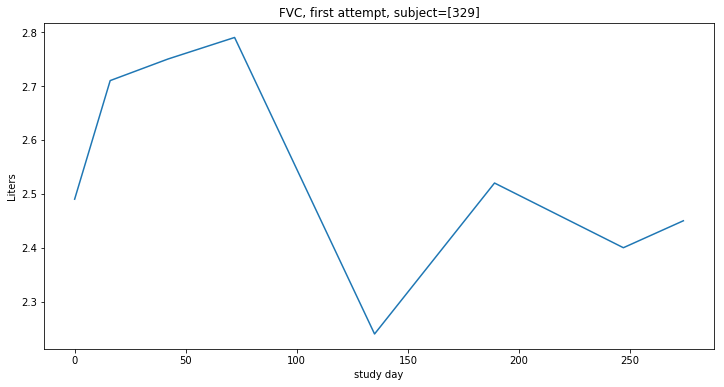

In [80]:
subject = fvc[ fvc['subject_id']==329]
plot_fvc_long(subject)

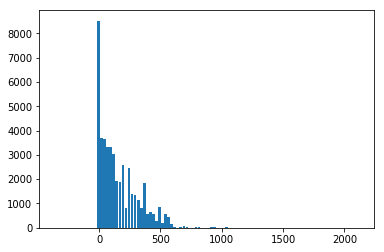

In [157]:
# hist of study days for fvc
plt.hist(fvc['study_day'], bins=100, rwidth=0.9)
plt.show()

## Labs  
- multi-subject
- make this tidy

In [35]:
labs = pd.read_csv("data/Labs.csv")

In [36]:
labs.head()

,subject_id,Test_Name,Test_Result,Test_Unit,Laboratory_Delta
0,329,Hemoglobin,130,g/L,0.0
1,329,Urine Color,YELLOW,NaN,0.0
2,329,Uric Acid,237.92,umol/L,0.0
3,329,ALPHA2-GLOBULIN,1,g/dL,0.0
4,329,Sodium,138,mmol/L,0.0


In [37]:
labs['study_day'] = labs["Laboratory_Delta"]
labs.drop("Laboratory_Delta", axis=1, inplace=True)

In [38]:
# only use lab data from placebo subjects to cut down on size
placebo_labs = labs.merge(placebo, how='inner', on='subject_id')

In [39]:
placebo_labs.head()

,subject_id,Test_Name,Test_Result,Test_Unit,study_day,Study_Arm
0,348,Bicarbonate,25.5,mmol/L,0.0,Placebo
1,348,Basophils,.6,%,0.0,Placebo
2,348,Bilirubin (Direct),1.71,umol/L,0.0,Placebo
3,348,Triglycerides,1.1516,mmol/L,0.0,Placebo
4,348,Urine Urobilinogen,Normal,NONE,0.0,Placebo


In [42]:
placebo_labs.shape

(945726, 6)

In [43]:
# don't run this unless you have to!!
#labs.pivot(columns='Test_Name', values=['Test_Result','Test_Unit'])

In [ ]:
labs.head()

## Functional responses from one subject

In [81]:
# plot one subject's questionaire scores.
# subject # 348
s348 = question[ question['subject_id']==348]

In [82]:
s348.head()

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day
12,348,4.0,4.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,1.0,NaN,NaN,39.0,4.0,4.0,4.0,0.0
13,348,4.0,4.0,4.0,3.0,2.0,NaN,2.0,4.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,4.0
14,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,52.0
15,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,61.0
16,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,99.0


In [83]:
Qs=list(s348.columns)
print(Qs)

['subject_id', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy', 'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 'Q10_Respiratory', 'ALSFRS_Total', 'ALSFRS_R_Total', 'R_1_Dyspnea', 'R_2_Orthopnea', 'R_3_Respiratory_Insufficiency', 'study_day']


## Merge single-entry tables

#### txt, death

In [695]:
# merge treatement data with death data
txt_d = txt.merge(death, how='left', on='subject_id')

In [696]:
print(txt_d.shape)
txt_d.head(10)

(9640, 4)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start
0,89,Active,1.0,218.0
1,329,Active,NaN,NaN
2,348,Placebo,NaN,NaN
3,406,Active,NaN,NaN
4,411,Active,1.0,141.0
5,649,Active,NaN,NaN
6,708,Active,1.0,250.0
7,902,Placebo,0.0,NaN
8,1025,Active,NaN,NaN
9,1064,Placebo,NaN,NaN


In [697]:
# number of placebo who died = 1088
# number of subjects who did not die = 447
# number of subjects with NaN = 1377
len(txt_d[ (txt_d['Subject_Died']==1) & (txt_d['Study_Arm']=='Placebo')])

1088

#### txt, death, riluzole

In [698]:
# merge df with riluzole
tdr = txt_d.merge(riluzole, how='left', on='subject_id')

In [699]:
print(tdr.shape)
tdr.head()

(9640, 5)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole
0,89,Active,1.0,218.0,1.0
1,329,Active,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0
3,406,Active,NaN,NaN,1.0
4,411,Active,1.0,141.0,1.0


#### tx, death, riluzole, onset dates

In [700]:
tdro = tdr.merge(onset, how='left', on='subject_id')

In [701]:
print(tdro.shape)
tdro.head(10)

(9640, 7)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta
0,89,Active,1.0,218.0,1.0,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0
3,406,Active,NaN,NaN,1.0,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN
5,649,Active,NaN,NaN,1.0,-341.0,NaN
6,708,Active,1.0,250.0,NaN,-1070.0,-986.0
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0
8,1025,Active,NaN,NaN,1.0,NaN,NaN
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0


In [702]:
tdro['death_day_since_onset'] = np.abs(tdro['Onset_Delta']) + tdro['death_days_trail_start']
print(tdro.shape)
tdro.head(10)

(9640, 8)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,death_day_since_onset
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN
5,649,Active,NaN,NaN,1.0,-341.0,NaN,NaN
6,708,Active,1.0,250.0,NaN,-1070.0,-986.0,1320.0
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0,NaN
8,1025,Active,NaN,NaN,1.0,NaN,NaN,NaN
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0,NaN


In [703]:
# number of subjects that died after disease onset, placebo
len( tdro[ (tdro['death_day_since_onset']>0) & (tdro['Study_Arm']=='Placebo')])

738

In [704]:
# number of subjects that died after disease onset, active
len( tdro[ (tdro['death_day_since_onset']>0) & (tdro['Study_Arm']=='Active')])

1010

In [705]:
placebo = tdro[ tdro['Study_Arm']=='Placebo']
print(placebo.shape)
placebo.head()

(2912, 8)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,death_day_since_onset
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,NaN
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0,NaN
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0,NaN
11,1312,Placebo,0.0,NaN,0.0,-247.0,-63.0,NaN
16,2132,Placebo,1.0,7.0,0.0,NaN,NaN,NaN


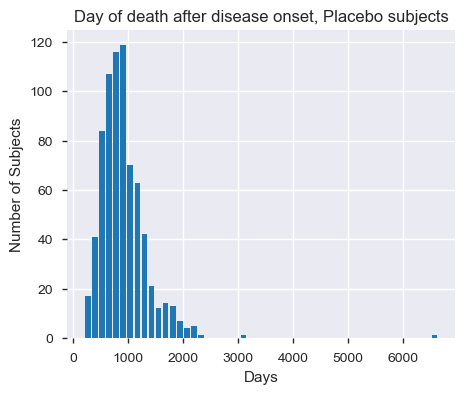

In [706]:
plt.figure(figsize=(5,4))
plt.hist(placebo['death_day_since_onset'], bins=50, rwidth=0.8)
plt.title("Day of death after disease onset, Placebo subjects")
plt.xlabel("Days")
plt.ylabel("Number of Subjects")
plt.show()

In [707]:
active = tdro[ tdro['Study_Arm']=='Active']
print(active.shape)
active.head()

(6728, 8)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,death_day_since_onset
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN
5,649,Active,NaN,NaN,1.0,-341.0,NaN,NaN


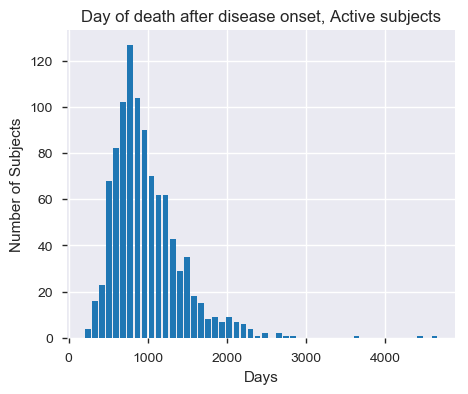

In [708]:
plt.figure(figsize=(5,4))
plt.hist(active['death_day_since_onset'], bins=50, rwidth=0.8)
plt.title("Day of death after disease onset, Active subjects")
plt.xlabel("Days")
plt.ylabel("Number of Subjects")
plt.show()

In [709]:
# add death windows
tdro['death_week'] = (tdro['death_day_since_onset']/7).apply(np.floor)

In [710]:
tdro['death_month'] = (tdro['death_day_since_onset']/30).apply(np.floor)

In [711]:
tdro.head(20)

,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,death_day_since_onset,death_week,death_month
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN
5,649,Active,NaN,NaN,1.0,-341.0,NaN,NaN,NaN,NaN
6,708,Active,1.0,250.0,NaN,-1070.0,-986.0,1320.0,188.0,44.0
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0,NaN,NaN,NaN
8,1025,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0,NaN,NaN,NaN


#### txt, death, riluzole, onset dates, demo

In [712]:
tdrod = tdro.merge(demo, how='left', on='subject_id')

In [713]:
print(tdrod.shape)
tdrod.head()

(9640, 23)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,death_day_since_onset,death_week,death_month,...,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,NaN,NaN,NaN,...,0,1,0,NaN,0,0,NaN,0.0,38.0,13870.0
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,NaN,NaN,NaN,...,0,0,0,NaN,1,0,NaN,0.0,52.0,18980.0
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN


In [740]:
# save version as csv
filename = 'clean_data/tdrod.csv'
tdrod.to_csv(filename, index=False)

## Functional Responses from Placebo subjects only

In [ ]:
# combine subjects with at least one questionaire
p = placebo.drop('Treatment_Group_Delta', axis=1)
p_qs = question.merge(p, how='inner', on='subject_id')

In [68]:
p_qs.head()

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Study_Arm
0,348,4.0,4.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,1.0,NaN,NaN,39.0,4.0,4.0,4.0,0.0,Placebo
1,348,4.0,4.0,4.0,3.0,2.0,NaN,2.0,4.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,4.0,Placebo
2,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,52.0,Placebo
3,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,61.0,Placebo
4,348,4.0,4.0,4.0,4.0,2.0,NaN,2.0,3.0,2.0,1.0,NaN,NaN,38.0,4.0,4.0,4.0,99.0,Placebo


In [69]:
# number questionaires per placebo subject
grp_p_qs = p_qs.groupby('subject_id')
n_p_qs = grp_p_qs['subject_id'].count()

In [70]:
n_p_qs.head()

subject_id
348     15
902      7
1064    16
1312     1
2540     4
Name: subject_id, dtype: int64

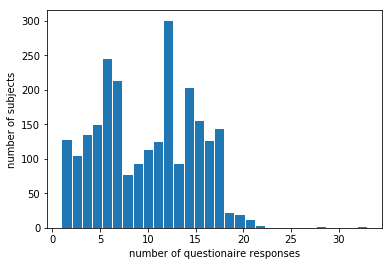

In [71]:
# how many visits per subject?
plt.hist(n_p_qs, rwidth=0.9, bins=30)
plt.xlabel("number of questionaire responses")
plt.ylabel("number of subjects")
plt.show()

### Plot stats

In [156]:
# plot question decline
def plot_question(df):
    '''
    plot the total functional test questionaire data
    input:
        df = pandas dataframe
        revised = 'R' or 'O', revised or original
    output:
        single plot
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))
    subjects = df['subject_id'].unique()
    for subject in subjects:
        sub = df[ df['subject_id'] == subject]
        if np.any(sub['Subject_Died']=='Yes'):
            color = 'red'
        else:
            color = 'gray'
        if np.max(sub['days_since_onset']) > 4000:
            continue
        if np.all(sub['ALSFRS_R_Total'].isnull()):
            ax1.plot(sub['days_since_onset'], sub['ALSFRS_Total'], color=color,
                     alpha=0.5, linewidth=1)
        else:
            ax2.plot(sub['days_since_onset'], sub['ALSFRS_R_Total'], color=color,
                     alpha=0.5, linewidth=1)
    ax1.set_title('Original Function Assess')
    ax2.set_title('Revised Function Assess')
    plt.ylim(bottom=0, top=50)
    plt.xlim(left=0, right=4000)
    plt.tight_layout()
    plt.show()

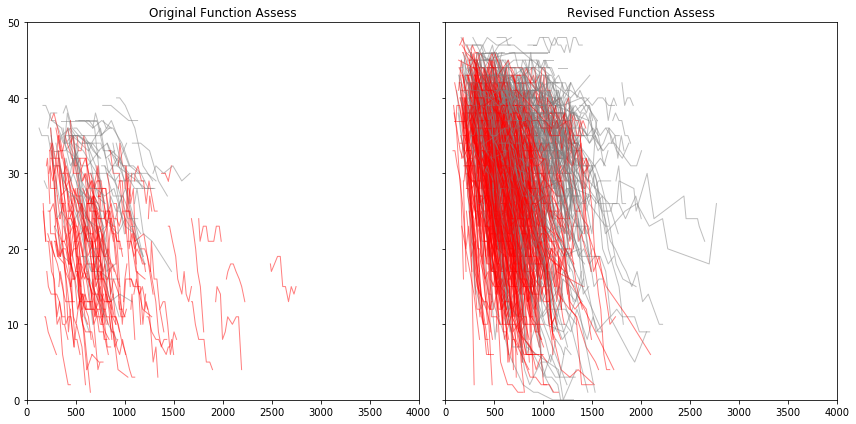

In [158]:
placebo = df[ df['Study_Arm'] == "Placebo"]
plot_question(placebo)

Notes on plots: many more subjects have the revised score. so many dead. seperate the deaths? length of survival? minimal score associated with death? how have some subjects have zero functionality and still alive? ANOVA? Is there a score level and below associated with death? 


## Progressor clusters

In [159]:
# perform cluster analysis on the subjects to find populations of 
# fast progressors, slow  progressors, and non-progressors.
from sklearn.cluster import KMeans

In [ ]:
km = KMeans(n_clusters=8, init=’k-means++’, n_init=10, max_iter=300, tol=0.0001, 
       precompute_distances=’auto’, verbose=0, random_state=None, copy_x=True, 
       n_jobs=None, algorithm=’auto’)

In [ ]:
# death within 1200 days of onset.


# Model

In [ ]:
# subset to only known dead people


In [44]:
from sklearn.ensemble import RandomForestRegressor

In [266]:
model = RandomForestRegressor()
model.fit()